In [2]:
!pip install xee

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.8 MB/s eta 0:00:00


#Import Libraries

In [3]:
import ee
import geemap
import xarray as xr
import xee

#Authentication Process

In [4]:
ee.Authenticate()
ee.Initialize(project='ee-aviresearch',opt_url='https://earthengine-highvolume.googleapis.com')

In [5]:
map = geemap.Map(basemap= 'SATELLITE')
map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [20]:
roi = map.draw_last_feature.geometry()
roi

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Feature.geometry",
    "arguments": {
      "feature": {
        "functionInvocationValue": {
          "functionName": "Feature",
          "arguments": {
            "geometry": {
              "functionInvocationValue": {
                "functionName": "GeometryConstructors.Polygon",
                "arguments": {
                  "coordinates": {
                    "constantValue": [
                      [
                        [
                          80.012205,
                          6.511815
                        ],
                        [
                          80.012205,
                          8.015716
                        ],
                        [
                          81.483956,
                          8.015716
                        ],
                        [
                          81.483956,
                          6.511815
                        ],
                        [
                          80.012205,
                          6.511815
                        ]
                      ]
                    ]
                  },
                  "geodesic": {
                    "constantValue": false
                  }
                }
              }
            }
          }
        }
      }
    }
  }
})

In [21]:
ndvi = ee.ImageCollection("NOAA/CDR/VIIRS/NDVI/V1").select('NDVI','QA').filterDate('2020','2021')
ndvi

In [22]:
def cloudMask(img):
  index = img.select('NDVI').multiply(0.0001)
  qa = img.select('QA')
  cloud = qa.bitwiseAnd(1 << 1).neq(0)
  shadow = qa.bitwiseAnd(1 << 2).neq(0)

  mask = cloud.Or(shadow).Not()

  return index.updateMask(mask).copyProperties(img,img.propertyNames())

In [23]:
ndvi_masked = ndvi.map(cloudMask)

In [24]:
ndvi_masked

In [25]:
ds = xr.open_dataset(ndvi_masked,engine='ee',crs='EPSG:4326',scale=0.05,geometry=roi)

In [26]:
ds

<xarray.Dataset> Size: 1MB
Dimensions:  (time: 366, lon: 29, lat: 30)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2020-01-01 2020-01-02 ... 2020-12-31
  * lon      (lon) float64 232B 80.04 80.09 80.14 80.19 ... 81.34 81.39 81.44
  * lat      (lat) float64 240B 6.537 6.587 6.637 6.687 ... 7.887 7.937 7.987
Data variables:
    NDVI     (time, lon, lat) float32 1MB ...
Attributes:
    crs:      EPSG:4326

In [27]:
sub = ds.sel(time=ds.time.dt.month==1)
sub

<xarray.Dataset> Size: 109kB
Dimensions:  (time: 31, lon: 29, lat: 30)
Coordinates:
  * time     (time) datetime64[ns] 248B 2020-01-01 2020-01-02 ... 2020-01-31
  * lon      (lon) float64 232B 80.04 80.09 80.14 80.19 ... 81.34 81.39 81.44
  * lat      (lat) float64 240B 6.537 6.587 6.637 6.687 ... 7.887 7.937 7.987
Data variables:
    NDVI     (time, lon, lat) float32 108kB ...
Attributes:
    crs:      EPSG:4326

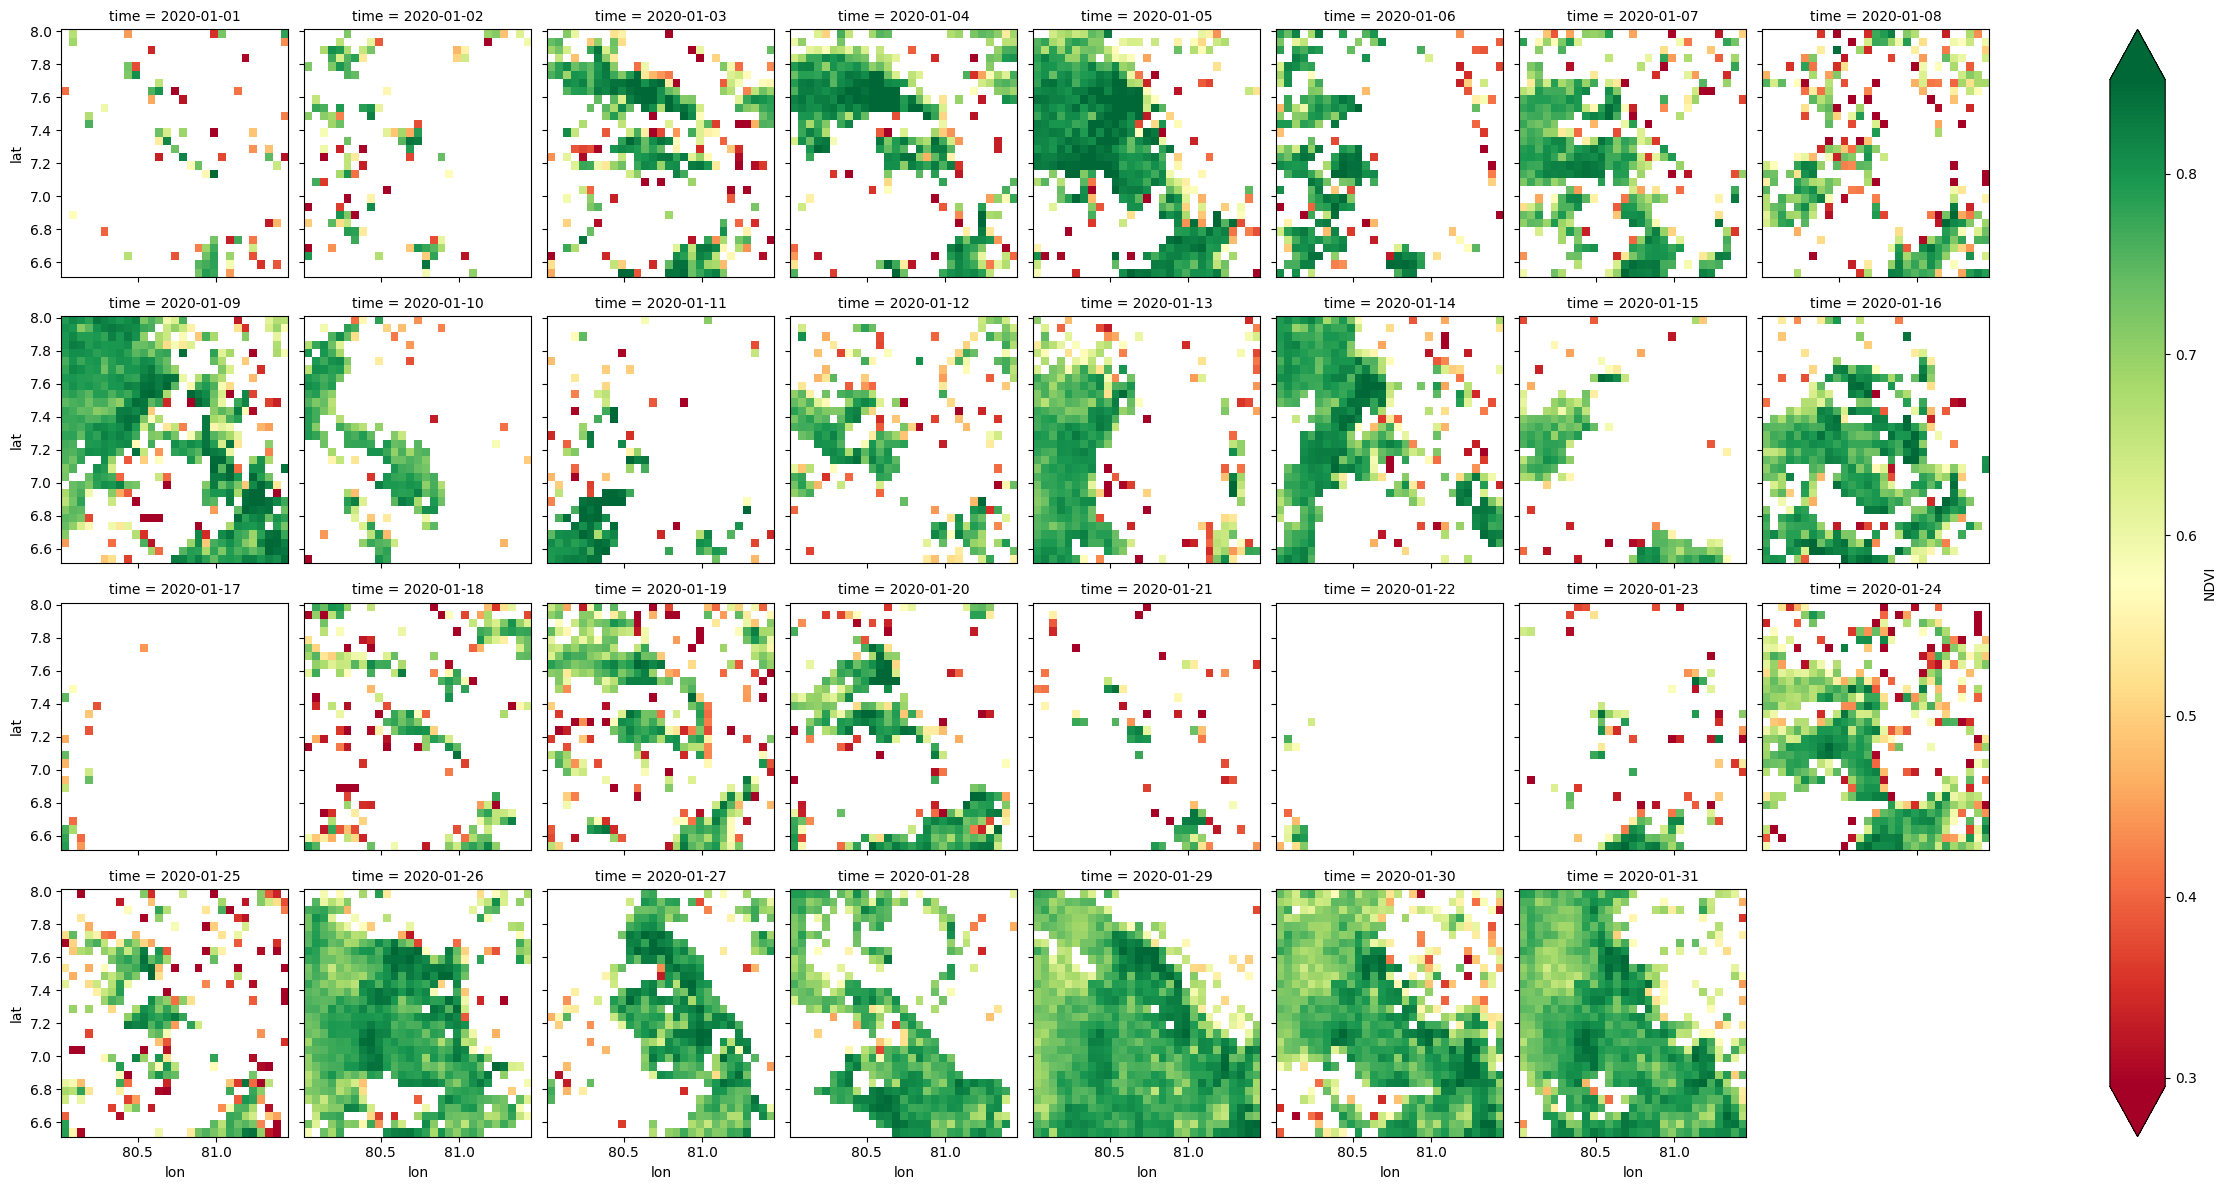

In [28]:
sub.NDVI.plot(x='lon',y='lat',col='time',col_wrap=8,robust=True,cmap='RdYlGn')

In [33]:
rolling = ds.rolling(time=14,min_periods=1,center=True).mean()

In [34]:
ds_filterd = ds.fillna(rolling)

In [35]:
sub2 = ds_filterd.sel(time= ds_filterd.time.dt.month ==1)

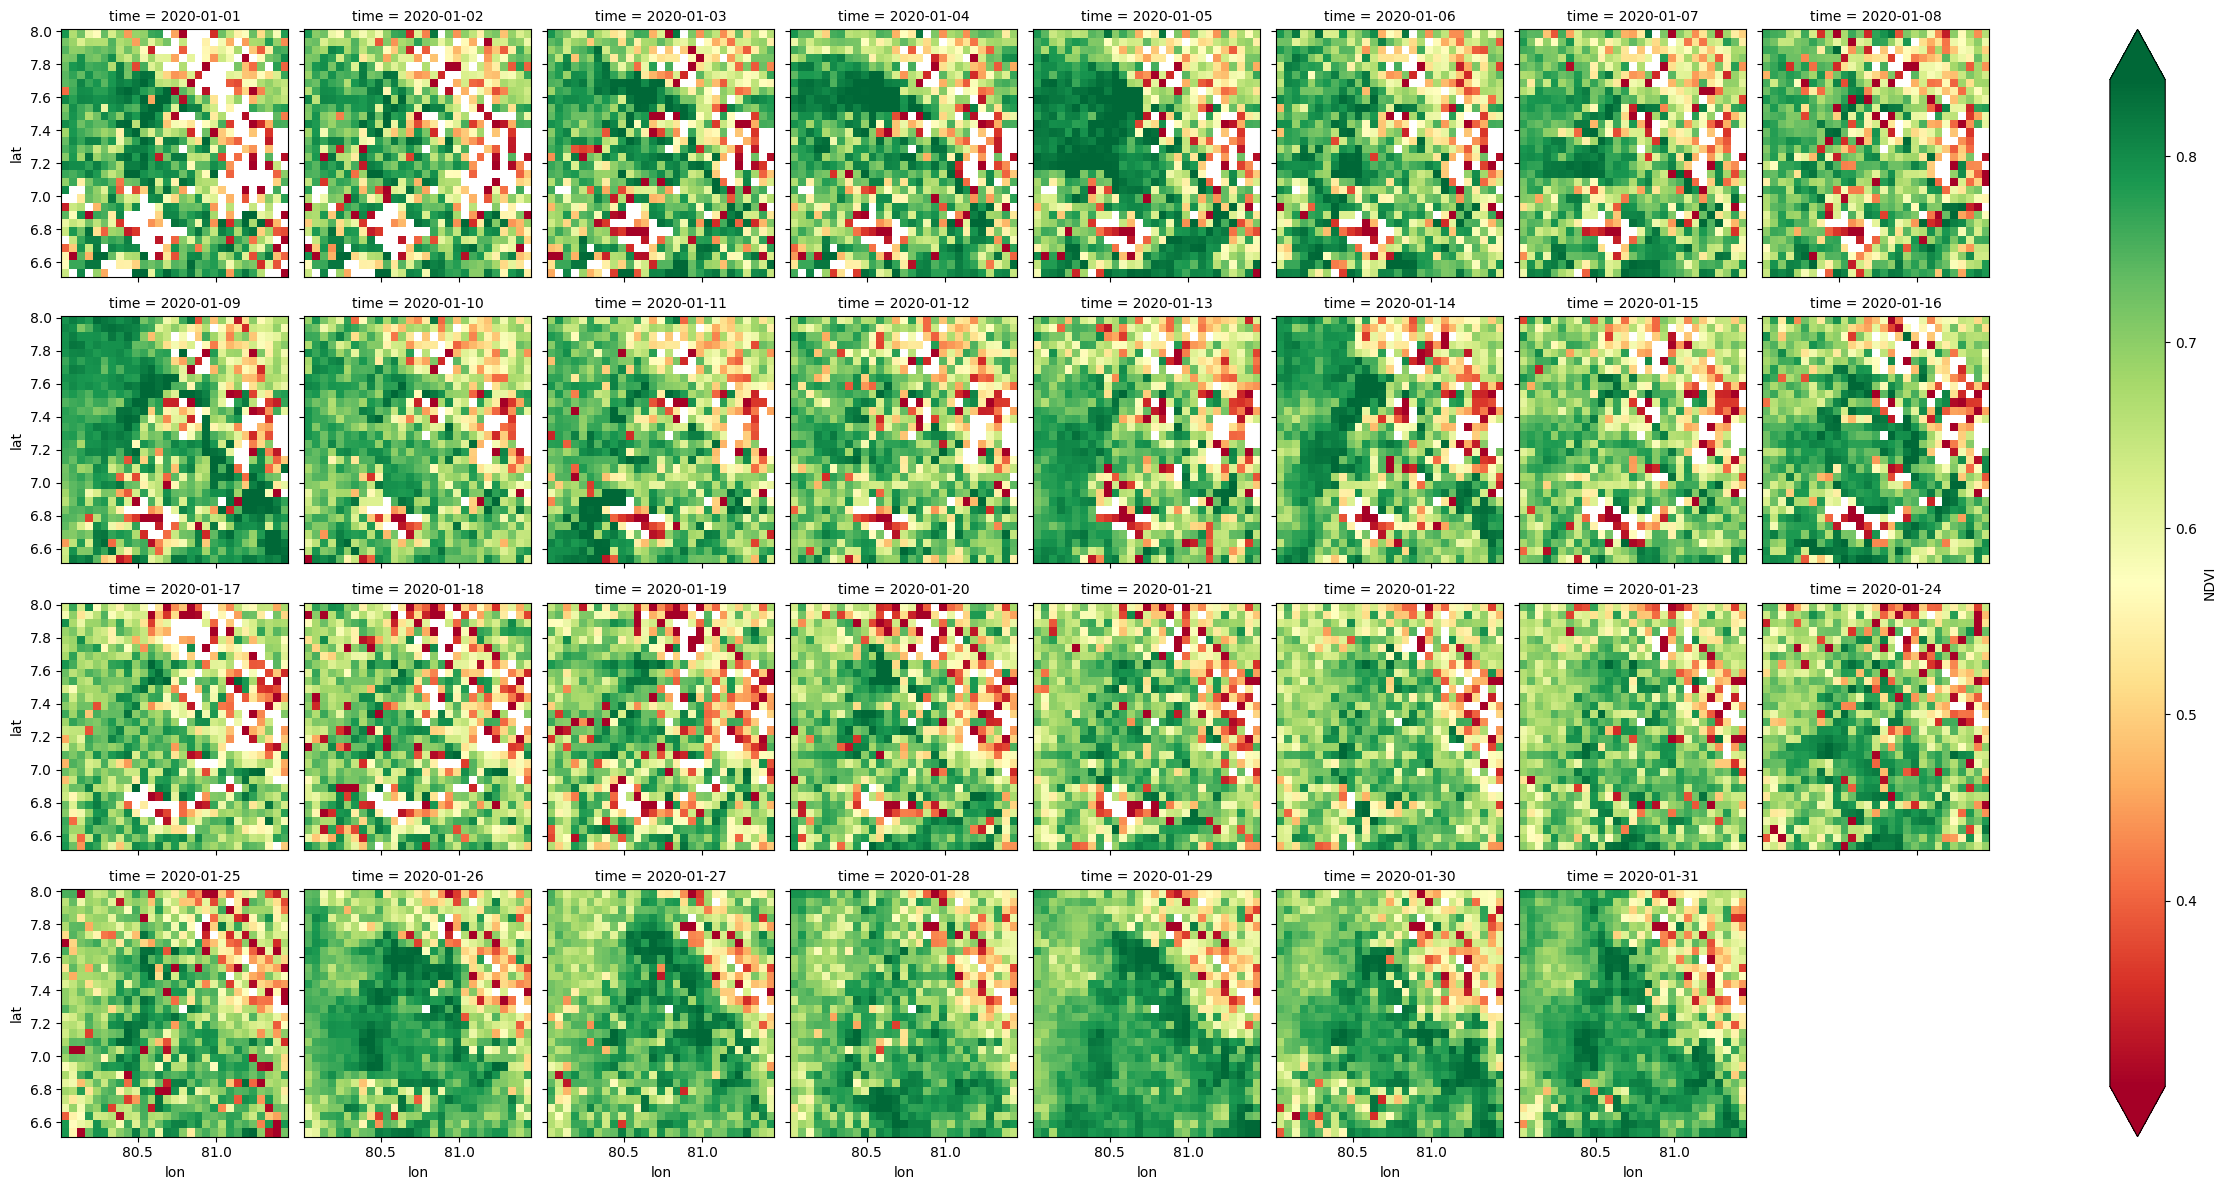

In [36]:
sub2.NDVI.plot(x='lon',y='lat',col='time',col_wrap=8,robust=True,cmap='RdYlGn')